In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
from cvxopt import matrix, solvers, blas

def get_first_values(data):
    print (data.iloc(0))

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2016, 8, 1)
shift = 1 #daily

symbols = [
    #'IJH', #iShares Core S&P 500 Mid-Cap
    #'IVW', #iShares S&P 500 Growth
    #'IJR', #iShares Core S&P 500 Small-Cap
    #'AAPL',
    #'GLD',
    #'SPY',
    'VTI',
    #'VTV',
    #'VOE',
    #'VBR',
    'VEA', # Foreign stocks
    'VWO', # Emerging markets
    'VIG', # Dividend stocks
    'VNQ', # Real Estate
    #'VTIP',
    #'SHV',
    #'MUB',
    'LQD', # Corporate Bonds
    'EMB', # EM Bonds
    #'VWOB'
 ]

data = {}
for symbol in symbols:
    data[symbol] = web.DataReader(symbol, 'yahoo', start, end)

price = pd.DataFrame({sym: dataframe['Adj Close'] for sym,dataframe in data.items()})

print (price)

                   EMB         LQD        VEA        VIG        VNQ  \
Date                                                                  
2010-01-04   74.321208   80.741873  28.676275  40.992070  34.468528   
2010-01-05   74.773277   81.127460  28.692606  40.966151  34.429844   
2010-01-06   74.875356   80.888398  28.700773  40.992070  34.367946   
2010-01-07   74.488913   80.988649  28.643616  41.199404  34.739326   
2010-01-08   74.576406   81.166021  28.953893  41.199404  34.484003   
2010-01-11   75.145134   81.250851  29.133529  41.441299  34.685167   
2010-01-12   75.159720   81.405083  28.798755  41.303075  34.104889   
2010-01-13   74.992016   81.065771  29.068205  41.519050  34.793486   
2010-01-14   74.598279   81.358814  29.231511  41.596801  34.762537   
2010-01-15   74.554533   81.327967  28.757929  41.164851  34.499477   
2010-01-19   74.671198   81.397375  29.076372  41.622717  35.203548   
2010-01-20   74.758691   81.343394  28.333337  41.216683  34.808960   
2010-0

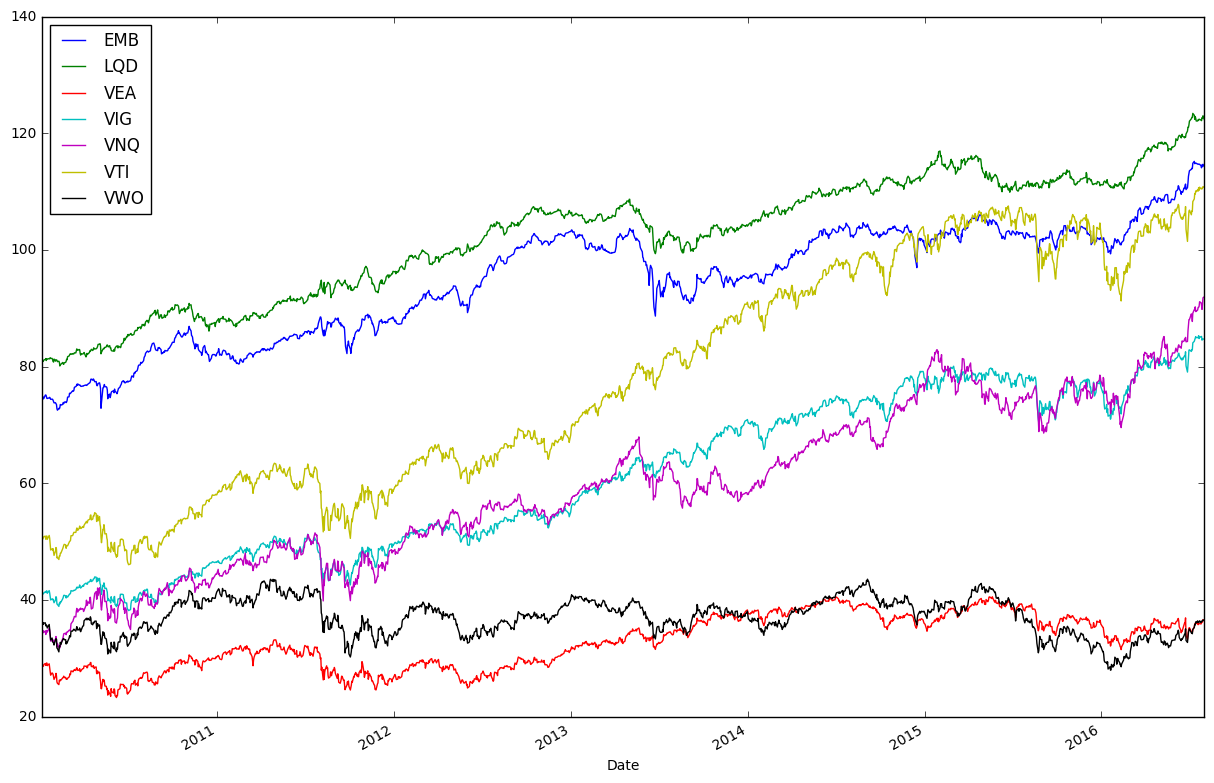

In [2]:
price.plot(figsize=(15, 10))
plt.show()

In [3]:
# 252 trading days a year
#avg_yearly_returns = (price/price.shift(252)-1).mean()

daily_returns = (price/price.shift(shift)) - 1
daily_returns_mean = daily_returns.mean()
daily_returns_variance = daily_returns.var()
daily_returns_covariance = daily_returns.cov()

#print ("Average Returns:\n%s\n" % (avg_yearly_returns*100))
print ("Daily Returns Mean:\n%s\n" % daily_returns_mean)
print ("Daily Returns Variance:\n%s" % daily_returns_variance)
print ("Daily Returns Covariance:\n%s" % daily_returns_covariance)

Daily Returns Mean:
EMB    0.000270
LQD    0.000257
VEA    0.000227
VIG    0.000479
VNQ    0.000670
VTI    0.000530
VWO    0.000111
dtype: float64

Daily Returns Variance:
EMB    0.000021
LQD    0.000012
VEA    0.000163
VIG    0.000080
VNQ    0.000154
VTI    0.000104
VWO    0.000199
dtype: float64
Daily Returns Covariance:
          EMB           LQD       VEA       VIG       VNQ       VTI  \
EMB  0.000021  5.392842e-06  0.000025  0.000015  0.000022  0.000018   
LQD  0.000005  1.217314e-05 -0.000003 -0.000003  0.000004 -0.000004   
VEA  0.000025 -3.080681e-06  0.000163  0.000100  0.000113  0.000117   
VIG  0.000015 -3.298218e-06  0.000100  0.000080  0.000085  0.000089   
VNQ  0.000022  3.830618e-06  0.000113  0.000085  0.000154  0.000100   
VTI  0.000018 -3.737921e-06  0.000117  0.000089  0.000100  0.000104   
VWO  0.000032 -7.844648e-07  0.000158  0.000105  0.000120  0.000122   

              VWO  
EMB  3.187121e-05  
LQD -7.844648e-07  
VEA  1.582778e-04  
VIG  1.046982e-04  
VNQ  1

In [4]:
def get_optimal_portfolio(avg_daily_returns, daily_returns_covariance, symbols, r_min):
    sigma = matrix(daily_returns_covariance.values)
    r_avg = matrix(avg_yearly_returns.values)
    n = len(symbols)
    P = sigma
    q = -matrix(avg_daily_returns)

    # inequality constraints Gx <= h
    # captures the constraints (avg_ret'x >= r_min) and (x >= 0)
    # and x <= 20
    G = matrix(np.concatenate((
                 -np.transpose(np.array(r_avg)), 
                 -np.identity(n)), 0))
    h = matrix(np.concatenate((
             -np.ones((1,1))*r_min, 
              np.zeros((n,1))), 0))
    # equality constraint Ax = b; captures the constraint sum(x) == 1
    A = matrix(1.0, (1,n))
    b = matrix(1.0)
    solvers.options['show_progress'] = False
    try:
        sol = solvers.qp(P, q, G, h, A, b)
    except ValueError:
        print ("ValueError")
        return None
    
    return sol['x']

rmins = np.arange(-1, daily_returns_mean.values.max(), 0.0000001)
rmins = np.append(rmins, daily_returns_mean.values.max())
#print (rmins)
p = [get_optimal_portfolio(daily_returns_mean, daily_returns_covariance, symbols, r) for r in rmins]
portfolios = [x for x in p if x is not None]

pbar = matrix(avg_yearly_returns.values)
S = matrix(daily_returns_covariance.values)
returns = [blas.dot(pbar, x) for x in portfolios]
risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]

plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
plt.show()

NameError: name 'avg_yearly_returns' is not defined

In [5]:
## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
m1 = np.polyfit(risks, returns, 2)

print (m1)

min_risk = np.min(risks)
max_risk = np.max(risks)

tar_sharpe = min_risk+((max_risk-min_risk)*.60)
print (tar_sharpe)
rate = (m1[0])*(tar_sharpe**2) + m1[1]*tar_sharpe + m1[2]
print (rate)

## CALCULATE THE OPTIMAL PORTFOLIO
wt = get_optimal_portfolio(avg_yearly_returns, daily_returns_covariance, symbols, rate)

for i in range(len(symbols)):
    print ("%s\t%f" % (symbols[i], (wt[i]*100)))

[ -1.13939326e+02   4.49942496e+00   5.00902720e-02]
0.00969245708844
0.0829968707412
VTI	24.999869
VEA	13.090248
VWO	0.000023
VIG	16.617641
VNQ	20.292455
LQD	24.999708
EMB	0.000055


In [6]:
val = np.matrix(avg_yearly_returns.values)
print (val*np.array(wt))

[[ 0.08299688]]
